In [ ]:
import os,glob,torch,torchaudio,torchvision
import os.path as osp
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchaudio.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import clear_output

## Xử lý tiền dữ liệu

torch.Size([1, 22400])


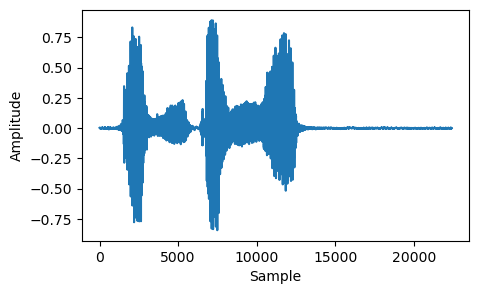

In [ ]:
# filename = './Datasets/data/VuMinhHieu_DangCongNhat_0.wav'
filename = './Datasets/data/TranBaoTuan_DangCongNhat_0.wav'
waveform, sample_rate = torchaudio.load(filename)

# Preprocessing steps
waveform = waveform.mean(dim=0, keepdim=True) # Convert stereo to mono
waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform) # Resample to 16kHz
waveform = torchaudio.transforms.Vad(sample_rate=16000)(waveform) # Voice activity detection to remove silence
print(waveform.shape) # (num_channels,num_samples)
# Plot waveform
plt.figure(figsize=(10, 3))
plt.plot(waveform.numpy()[0])
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

torch.Size([201, 141])


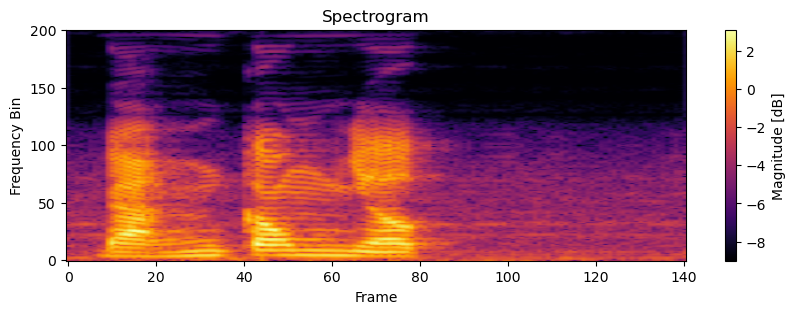

In [ ]:
# Convert waveform to spectrogram
specgram_transform = torchaudio.transforms.Spectrogram(
    n_fft=400,hop_length=160,win_length=400,window_fn=torch.hann_window)
spectrogram = specgram_transform(waveform.squeeze())

# Convert to dB scale
spectrogram = torch.log10(spectrogram + 1e-9)
print(spectrogram.shape) # (frequencies,time_steps)
# Plot spectrogram
plt.figure(figsize=(10, 3))
plt.imshow(spectrogram.squeeze(), cmap='inferno', origin='lower', aspect='auto')
plt.colorbar().set_label('Magnitude [dB]')
plt.xlabel('Frame')
plt.ylabel('Frequency Bin')
plt.title('Spectrogram')
plt.show()

torch.Size([201, 60, 1])


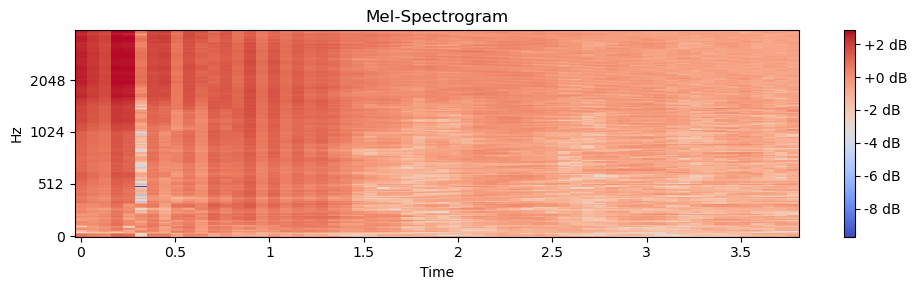

In [ ]:
# Convert spectrogram to mel-spectrogram
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=16000,n_fft=400,hop_length=640,win_length=400,n_mels=60, pad = 2**7)
mel_spectrogram = mel_transform(spectrogram)
# Normalize mel-spectrogram
mel_spectrogram = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)
mel_spectrogram -= mel_spectrogram.mean()
mel_spectrogram /= mel_spectrogram.std()
print(mel_spectrogram.shape)

# Plot mel-spectrogram
plt.figure(figsize=(10, 3))
librosa.display.specshow(mel_spectrogram.squeeze().numpy(), sr=sample_rate\
                         , x_axis='time', y_axis='mel', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.show()

torch.Size([1, 201, 20])


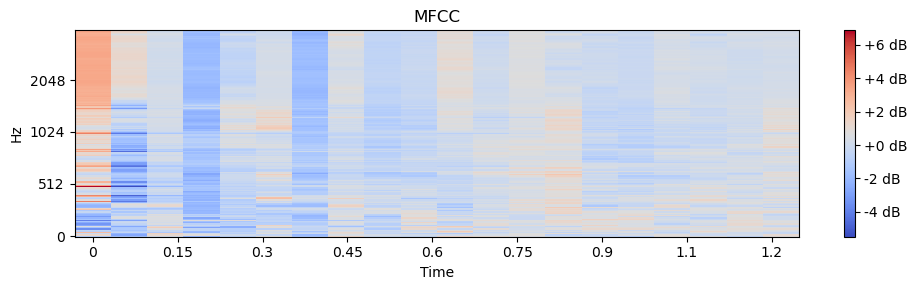

In [ ]:
# Convert to MFCC
mfcc_transform = transforms.MFCC(sample_rate=16000, n_mfcc=20 , melkwargs=
            {'n_fft': 400, 'hop_length': 640, 'win_length': 400 , 'pad' : 2**7})
mfcc = mfcc_transform(mel_spectrogram.squeeze())
mfcc -= mfcc.mean()
mfcc /= mfcc.std()
print(mfcc.shape)

# Plot mfcc
plt.figure(figsize=(10, 3))
librosa.display.specshow(mfcc.squeeze().numpy(),\
                         sr=sample_rate, x_axis='time', y_axis='mel', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.tight_layout()
plt.show()

## Tạo dataset và dataloader

In [ ]:
## Create dataset
class AudioDataset(Dataset):
    def __init__(self, filenames):
        self.filenames = filenames
        self.specgram_transform  = transforms.Spectrogram(
                n_fft=400,hop_length=160,win_length=400,window_fn=torch.hann_window)
        self.mel_transform = transforms.MelSpectrogram(
                sample_rate=16000,n_fft=400,hop_length=640,win_length=400,n_mels=60, pad = 2**7)
        self.mfcc_transform = transforms.MFCC(sample_rate=16000, n_mfcc=20 , melkwargs=
            {'n_fft': 400, 'hop_length': 640, 'win_length': 400 , 'pad' : 2**7})
        
    def __getitem__(self, idx):
        waveform, sample_rate = torchaudio.load(self.filenames[idx])
        waveform = waveform.mean(dim=0, keepdim=True) # Convert stereo to mono
        waveform = transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform) # Resample to 16kHz
        waveform = transforms.Vad(sample_rate=16000)(waveform) # Voice activity detection to remove silence
        
        spectrogram = specgram_transform(waveform.squeeze())
        # Convert to dB scale
        spectrogram = torch.log10(spectrogram + 1e-9)
        
        mel_spectrogram = mel_transform(spectrogram)
        # Normalize mel-spectrogram
        mel_spectrogram = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)
        mel_spectrogram -= mel_spectrogram.mean()
        mel_spectrogram /= mel_spectrogram.std()
        
        mfcc = mfcc_transform(mel_spectrogram.squeeze())
        mfcc -= mfcc.mean()
        mfcc /= mfcc.std()
        mfcc = mfcc.transpose(2,0)
        mfcc = mfcc.transpose(2,1)
        
        label = self.filenames[idx].split('/')[-1].split('\\')[-1].split('_')[0]
        if label == 'LamMinhTrung':
            label = 0
        elif label == 'TranBaoTuan':
            label = 1
        else:
            label = 2
        
        return mfcc, label # (0: LamMinhTrung, 1: TranBaoTuan , 2: VuMinhHieu)
    
    def __len__(self):
        return len(self.filenames)

In [ ]:
# Function to get the data path
def data_path():
    root = './Datasets/data/'
    target = osp.join(root+'/*.wav')
    path_list = []
    for path in glob.glob(target):
        path_list.append(path)
    
    return path_list

In [ ]:
# Create training , validation data
data = data_path()
print(len(data))
train_path, val_path = train_test_split(data,test_size=0.2, random_state=32)
len(train_path),len(val_path)

1399


(1119, 280)

In [ ]:
# Testing the class dataset
dataset = AudioDataset(data)
train_data = AudioDataset(train_path)
val_data  = AudioDataset(val_path)
print(dataset.__getitem__(100))

(tensor([[[ 0.9903,  0.0218, -0.2531,  ...,  0.2602,  0.7858,  0.6740],
         [ 1.6493,  0.5736, -0.9744,  ...,  0.1865,  0.2813,  0.2580],
         [ 0.7877, -0.3647, -0.6452,  ...,  0.2761,  0.1220,  0.2289],
         ...,
         [ 3.6269,  1.0838,  0.0236,  ...,  0.1294, -0.0628,  0.2108],
         [ 3.6018,  1.0926,  0.0110,  ...,  0.1871, -0.0487,  0.1771],
         [ 3.8142,  1.1574,  0.0074,  ...,  0.1658,  0.0085,  0.1950]]]), 0)


In [ ]:
## Create dataloader
batch_size = 1
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [ ]:
# Testing dataloader
# Iterate through the dataloader
for batch_idx, (data, label) in enumerate(val_dataloader):
    print('Batch : ',batch_idx)
    print('Data Shape : ',data.shape) 
    print('Label : ',label)
    if batch_idx == 2:
        break

Batch :  0
Data Shape :  torch.Size([1, 1, 201, 20])
Label :  tensor([1])
Batch :  1
Data Shape :  torch.Size([1, 1, 201, 20])
Label :  tensor([0])
Batch :  2
Data Shape :  torch.Size([1, 1, 201, 20])
Label :  tensor([0])


## Building CNN model , Loss , Optimizer

In [ ]:
## Create a CNN model
class SpeakerCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SpeakerCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), padding=(1,1))
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=(1,1))
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=(1,1))
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2))
        
        self.fc1 = nn.Linear(in_features=3200, out_features=512)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [ ]:
speakerCNN = SpeakerCNN()
print(speakerCNN)

SpeakerCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3200, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_featur

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
speakerCNN = SpeakerCNN().to(device)
# Create loss
criterion = nn.CrossEntropyLoss()
# Create optimizer
optimizer = optim.Adam(speakerCNN.parameters(), lr=0.001)

cuda


## Training model phase

In [ ]:
if not os.path.isfile('speakerCNN.pt'):
    # Train the model
    for epoch in range(5):
        running_loss = 0.0
        for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = speakerCNN(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # Print every 100 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

    print('Finished Training')
    
    #Saving model
    torch.save(speakerCNN.state_dict(), 'speakerCNN.pt')
else:
    print('Model already training and be saved .!')

Model already training and be saved .!


## Evaluate model

In [ ]:
#Load model
if os.path.isfile('speakerCNN.pt'):
    speakerCNN = SpeakerCNN().to(device)
    speakerCNN.load_state_dict(torch.load('speakerCNN.pt'))

In [ ]:
from sklearn.metrics import accuracy_score
# Evaluate on validation set
speakerCNN.eval()
y_true = []
y_pred = []
total = len(val_dataloader)
for i,datas in enumerate(val_dataloader, 0):
    print("Evaluation state : %0.3f %% " % (i*100/total))
    inputs,labels = datas
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = speakerCNN(inputs)
    _, predicted = torch.max(outputs, 1)
    y_true += labels.cpu().numpy().tolist()
    y_pred += predicted.cpu().numpy().tolist()
    clear_output(wait=True)
print("Evaluation state : 100 %")
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print('Accuracy:', accuracy)

Evaluation state : 100 %% 
Accuracy: 0.9535714285714286


In [ ]:
# Define function to processing test data
def get_test(test_path):
    
    waveform, sample_rate = torchaudio.load(test_path)

    # Preprocessing steps
    waveform = waveform.mean(dim=0, keepdim=True) # Convert stereo to mono
    waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform) # Resample to 16kHz
    waveform = torchaudio.transforms.Vad(sample_rate=16000)(waveform) # Voice activity detection to remove silence

    # Convert waveform to spectrogram
    specgram_transform = torchaudio.transforms.Spectrogram(
        n_fft=400,hop_length=160,win_length=400,window_fn=torch.hann_window)
    spectrogram = specgram_transform(waveform.squeeze())

    # Convert spectrogram to mel-spectrogram
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=16000,n_fft=400,hop_length=640,win_length=400,n_mels=60, pad = 2**7)
    mel_spectrogram = mel_transform(spectrogram)
    # Normalize mel-spectrogram
    mel_spectrogram = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)
    mel_spectrogram -= mel_spectrogram.mean()
    mel_spectrogram /= mel_spectrogram.std()
    
    # Convert to MFCC
    mfcc_transform = transforms.MFCC(sample_rate=16000, n_mfcc=20 , melkwargs=
                {'n_fft': 400, 'hop_length': 640, 'win_length': 400 , 'pad' : 2**7})
    mfcc = mfcc_transform(mel_spectrogram.squeeze())
    mfcc -= mfcc.mean()
    mfcc /= mfcc.std()
    mfcc = mfcc.transpose(2,0)
    mfcc = mfcc.transpose(2,1)
    
    return mfcc.unsqueeze(0)

In [ ]:
# Testing a sample
test_path = './Datasets/test/testing_1.wav' 
test = get_test(test_path).to(device)
outputs = speakerCNN(test)
_, predicted = torch.max(outputs, 1)
if predicted.cpu().numpy() == 0:
    print('LamMinhTrung')
elif predicted == 1:
    print('TranBaoTuan')
else:
    print('VuMinhHieu')

LamMinhTrung
